In [1]:
import pyspark
# import os
# import sys
# from pyspark import SparkContext
# os.environ['PYSPARK_PYTHON'] = sys.executable
# os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.config("spark.driver.memory", "16g").\
appName('chapter_8').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/08 15:27:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:
stocks = spark.read.csv(["stocks/ABAX.csv","stocks/AAME.csv","stocks/AEPI.csv"],
                        header='true', inferSchema='true')

stocks.show(2)

+---------+-----+-----+-----+-----+------+
|     Date| Open| High|  Low|Close|Volume|
+---------+-----+-----+-----+-----+------+
|31-Dec-13|52.94|54.37|52.25|52.83| 79429|
|30-Dec-13|50.36|54.10|50.36|52.95|131095|
+---------+-----+-----+-----+-----+------+
only showing top 2 rows



In [9]:
from pyspark.sql import functions as fun
stocks = stocks.withColumn("Symbol", fun.input_file_name()).\
withColumn("Symbol",
           fun.element_at(fun.split("Symbol", "/"), -1)).\
withColumn("Symbol",
           fun.element_at(fun.split("Symbol", "\."), 1))
stocks.show(2)

+---------+-----+-----+-----+-----+------+------+
|     Date| Open| High|  Low|Close|Volume|Symbol|
+---------+-----+-----+-----+-----+------+------+
|31-Dec-13|52.94|54.37|52.25|52.83| 79429|  AEPI|
|30-Dec-13|50.36|54.10|50.36|52.95|131095|  AEPI|
+---------+-----+-----+-----+-----+------+------+
only showing top 2 rows



In [10]:
factors = spark.read.csv(["stocks/ABAX.csv","stocks/AAME.csv","stocks/AEPI.csv"], 
                         header='true', inferSchema='true')
factors = factors.withColumn("Symbol", fun.input_file_name()).\
withColumn("Symbol",
           fun.element_at(fun.split("Symbol", "/"), -1)).\
withColumn("Symbol",
           fun.element_at(fun.split("Symbol", "\."), 1))

In [11]:
from pyspark.sql import Window

stocks = stocks.withColumn('count', fun.count('Symbol').\
                           over(Window.partitionBy('Symbol'))).\
filter(fun.col('count') > 260*5 + 10)

In [12]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

In [13]:
stocks = stocks.withColumn('Date',
                           fun.to_date(fun.to_timestamp(fun.col('Date'),
                                                        'dd-MMM-yy')))
stocks.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- count: long (nullable = false)



In [14]:
from datetime import datetime
stocks = stocks.filter(fun.col('Date') >= datetime(2009, 10, 23)).\
filter(fun.col('Date') <= datetime(2014, 10, 23))

In [15]:
factors = factors.withColumn('Date',
                             fun.to_date(fun.to_timestamp(fun.col('Date'),
                                                          'dd-MMM-yy')))
factors = factors.filter(fun.col('Date') >= datetime(2009, 10, 23)).\
filter(fun.col('Date') <= datetime(2014, 10, 23))

In [16]:
stocks_pd_df = stocks.toPandas()
factors_pd_df = factors.toPandas()
factors_pd_df.head(5)

/home/lplab/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


,Date,Open,High,Low,Close,Volume,Symbol
0,2013-12-31,52.94,54.37,52.25,52.83,79429,AEPI
1,2013-12-30,50.36,54.10,50.36,52.95,131095,AEPI
2,2013-12-27,50.38,50.80,49.67,50.52,54354,AEPI
3,2013-12-26,50.50,51.19,49.67,50.00,74414,AEPI
4,2013-12-24,49.85,50.60,49.66,49.99,36872,AEPI


In [17]:
n_steps = 10
def my_fun(x):
    return ((x.iloc[-1] - x.iloc[0]) / x.iloc[0])

stock_returns = stocks_pd_df.groupby('Symbol').Close.\
rolling(window=n_steps).apply(my_fun)
factors_returns = factors_pd_df.groupby('Symbol').Close.\
rolling(window=n_steps).apply(my_fun)

stock_returns = stock_returns.reset_index().\
sort_values('level_1').\
reset_index()
factors_returns = factors_returns.reset_index().\
sort_values('level_1').\
reset_index()

In [18]:
# Create combined stocks DF
stocks_pd_df_with_returns = stocks_pd_df.\
assign(stock_returns = \
stock_returns['Close'])

# Create combined factors DF
factors_pd_df_with_returns = factors_pd_df.\
assign(factors_returns = \
       factors_returns['Close'],
       factors_returns_squared = \
       factors_returns['Close']**2)
factors_pd_df_with_returns = factors_pd_df_with_returns.\
pivot(index='Date',
      columns='Symbol',
      values=['factors_returns', \
              'factors_returns_squared'])
factors_pd_df_with_returns.columns = factors_pd_df_with_returns.\
columns.\
to_series().\
str.\
join('_').\
reset_index()[0]

factors_pd_df_with_returns = factors_pd_df_with_returns.\
reset_index()

print(factors_pd_df_with_returns.head(1))

0        Date  factors_returns_AAME  factors_returns_ABAX  \
0  2009-10-23              0.111111               0.10064   

0  factors_returns_AEPI  factors_returns_squared_AAME  \
0              0.097994                      0.012346   

0  factors_returns_squared_ABAX  factors_returns_squared_AEPI  
0                      0.010128                      0.009603  


In [19]:
print(factors_pd_df_with_returns.columns)

Index(['Date', 'factors_returns_AAME', 'factors_returns_ABAX',
       'factors_returns_AEPI', 'factors_returns_squared_AAME',
       'factors_returns_squared_ABAX', 'factors_returns_squared_AEPI'],
      dtype='object', name=0)


In [20]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# For each stock, create input DF for linear regression training

stocks_factors_combined_df = pd.merge(stocks_pd_df_with_returns,
                                      factors_pd_df_with_returns,
                                      how="left", on="Date")

feature_columns = list(stocks_factors_combined_df.columns[-6:])

with pd.option_context('mode.use_inf_as_na', True):
    stocks_factors_combined_df = stocks_factors_combined_df.\
    dropna(subset=feature_columns \
           + ['stock_returns'])


def find_ols_coef(df):
    y = df[['stock_returns']].values
    X = df[feature_columns]
    
    regr = LinearRegression()
    regr_output = regr.fit(X, y)
    
    return list(df[['Symbol']].values[0]) + \
                list(regr_output.coef_[0])

coefs_per_stock = stocks_factors_combined_df.\
groupby('Symbol').\
apply(find_ols_coef)

coefs_per_stock = pd.DataFrame(coefs_per_stock).reset_index()

coefs_per_stock.columns = ['symbol', 'factor_coef_list']

coefs_per_stock = pd.DataFrame(coefs_per_stock.\
                               factor_coef_list.tolist(),
                               index=coefs_per_stock.index,
                               columns = ['Symbol'] + feature_columns)

coefs_per_stock

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_11544/3065362436.py:12: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/lib/python3/dist-packages/sklearn/utils/validation.py:507: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any()):
/usr/lib/python3/dist-packages/sklearn/utils/validation.py:507: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any()):
/usr/lib/python3/dist-packages/sklearn/utils/validati

,Symbol,factors_returns_AAME,factors_returns_ABAX,factors_returns_AEPI,factors_returns_squared_AAME,factors_returns_squared_ABAX,factors_returns_squared_AEPI
0,AAME,1.000000e+00,3.350059e-16,-1.273186e-17,-7.598231e-18,1.460911e-18,-2.187836e-18
1,ABAX,1.983357e-16,1.000000e+00,1.110223e-16,2.775558e-17,-8.326673e-17,-9.714451e-17
2,AEPI,-1.762984e-16,8.881784e-16,1.000000e+00,1.283695e-16,1.283695e-16,1.908196e-17


<AxesSubplot:ylabel='Density'>

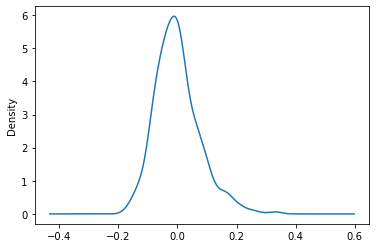

In [21]:
samples = factors_returns.loc[factors_returns.Symbol == \
                              factors_returns.Symbol.unique()[0]]['Close']
samples.plot.kde()

In [22]:
f_1 = factors_returns.loc[factors_returns.Symbol == \
                          factors_returns.Symbol.unique()[0]]['Close']
f_2 = factors_returns.loc[factors_returns.Symbol == \
                          factors_returns.Symbol.unique()[1]]['Close']
f_3 = factors_returns.loc[factors_returns.Symbol == \
                          factors_returns.Symbol.unique()[2]]['Close']

print(f_1.size,len(f_2),f_3.size)
pd.DataFrame({'f1': list(f_1)[1:1040], 'f2': list(f_2)[1:1040], 'f3':
              list(f_3)}).corr()

1053 1053 1039


,f1,f2,f3
f1,1.000000,0.275057,-0.015415
f2,0.275057,1.000000,0.031370
f3,-0.015415,0.031370,1.000000


In [23]:
factors_returns_cov = pd.DataFrame({'f1': list(f_1)[1:1040],
                                    'f2': list(f_2)[1:1040],
                                    'f3': list(f_3)})\
.cov().to_numpy()
factors_returns_mean = pd.DataFrame({'f1': list(f_1)[1:1040],
                                     'f2': list(f_2)[1:1040],
                                     'f3': list(f_3)}).\
mean()

In [24]:
from numpy.random import multivariate_normal

multivariate_normal(factors_returns_mean, factors_returns_cov)

array([-0.09690199, -0.01609523, -0.17216629])

In [25]:
b_coefs_per_stock = spark.sparkContext.broadcast(coefs_per_stock)
b_feature_columns = spark.sparkContext.broadcast(feature_columns)
b_factors_returns_mean = spark.sparkContext.broadcast(factors_returns_mean)
b_factors_returns_cov = spark.sparkContext.broadcast(factors_returns_cov)

In [26]:
from pyspark.sql.types import IntegerType

parallelism = 1000
num_trials = 1000000
base_seed = 1496

seeds = [b for b in range(base_seed,
                          base_seed + parallelism)]
seedsDF = spark.createDataFrame(seeds, IntegerType())

seedsDF = seedsDF.repartition(parallelism)

In [27]:
import random
from numpy.random import seed

from pyspark.sql.types import LongType, ArrayType, DoubleType
from pyspark.sql.functions import udf

def calculate_trial_return(x):
    # return x
    trial_return_list = []
    for i in range(int(num_trials/parallelism)):
        random_int = random.randint(0, num_trials*num_trials)
        
        seed(x)
        
        random_factors = multivariate_normal(b_factors_returns_mean.value,
                                             b_factors_returns_cov.value)
        
        coefs_per_stock_df = b_coefs_per_stock.value
        returns_per_stock = (coefs_per_stock_df[b_feature_columns.value] *
                             (list(random_factors) + list(random_factors**2)))
        
        trial_return_list.append(float(returns_per_stock.sum(axis=1).sum()/
                                       b_coefs_per_stock.value.size))
        
        return trial_return_list

udf_return = udf(calculate_trial_return, ArrayType(DoubleType()))

In [28]:
from pyspark.sql.functions import col, explode

trials = seedsDF.withColumn("trial_return", udf_return(col("value")))
trials = trials.select('value', explode('trial_return').alias('trial_return'))

trials.cache()

DataFrame[value: int, trial_return: double]

In [29]:
trials.approxQuantile('trial_return', [0.05], 0.0)

/home/lplab/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/lplab/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/lplab/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/lplab/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/lplab/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or

[-0.006719578482184056]

In [30]:
trials.orderBy(col('trial_return').asc()).\
limit(int(trials.count()/20)).\
agg(fun.avg(col("trial_return"))).show()

+--------------------+
|   avg(trial_return)|
+--------------------+
|-0.00671957848218...|
+--------------------+



<AxesSubplot:>

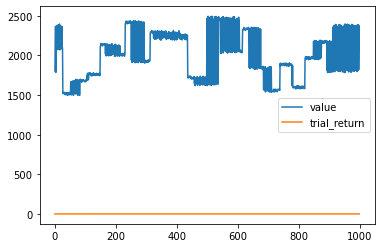

In [31]:
import pandas
mytrials=trials.toPandas()
mytrials.plot.line()